In [2]:
import xarray as xr

In [2]:

import zarr
from fsspec.implementations.http import HTTPFileSystem
fs = HTTPFileSystem()

In [ ]:
# %%
# http_map = fs.get_mapper("https://eerie.cloud.dkrz.de/datasets/icon-esm-er.eerie-control-1950.ocean.gr025.2d_monthly_mean/zarr")
http_map = fs.get_mapper("https://eerie.cloud.dkrz.de/datasets/icon-esm-er.eerie-control-1950.ocean.native.2d_daily_mean/zarr")
# open as a zarr group
zg = zarr.open_consolidated(http_map, mode="r")
ds = xr.open_zarr(http_map, consolidated=True)
ds

### load data

In [3]:
path_2_data = '/Users/mepke/python/tapgfd/data/swift.dkrz.de/tapgfd_workshop/'
ds_tgrid    = xr.open_dataset(f'{path_2_data}icon-esm-er.eerie-control-1950.ocean.native.2d_grid_minimal.nc')
ds          = xr.open_dataset(f'{path_2_data}icon-esm-er.eerie-control-1950.ocean.native.2d_daily_mean_snapshot.nc')


In [6]:
ds_sel = ds.to.squeeze()
ds_sel = ds_sel.rename({"lon": "clon", "lat": "clat"})
ds_sel

<xarray.DataArray 'to' (ncells: 14886338)> Size: 60MB
[14886338 values with dtype=float32]
Coordinates:
    depth    float64 8B 1.0
    clat     (ncells) float64 119MB ...
    clon     (ncells) float64 119MB ...
    time     datetime64[ns] 8B ...
Dimensions without coordinates: ncells
Attributes:
    CDI_grid_type:                unstructured
    code:                         2
    long_name:                    sea water potential temperature
    number_of_grid_in_reference:  1
    standard_name:                sea_water_potential_temperature
    units:                        deg C

In [8]:
import datashader as dshader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cmocean
from datashader.mpl_ext import dsshow

In [9]:
def basic_dshader_plot(ds_variable, lon_range, lat_range, vminmax=None, cmap='plasma'):
    fig, ax = plt.subplots(figsize=(10,5))

    # Get the data in a dataframe to use dasher plot
    df = pd.DataFrame(data={
        "var": np.squeeze(ds_variable.values),
        "x": np.rad2deg(ds_variable.clon.values),
        "y": np.rad2deg(ds_variable.clat.values),
    },)
    df = df[(df['x']>lon_range[0]) & (df['x']<lon_range[1]) & 
            (df['y']>lat_range[0]) & (df['y']<lat_range[1])]
    
    artist = dsshow(df, dshader.Point('x', 'y'), dshader.mean('var'), cmap=cmap, vmax=vminmax[1], vmin=vminmax[0], ax=ax)

    return fig, ax

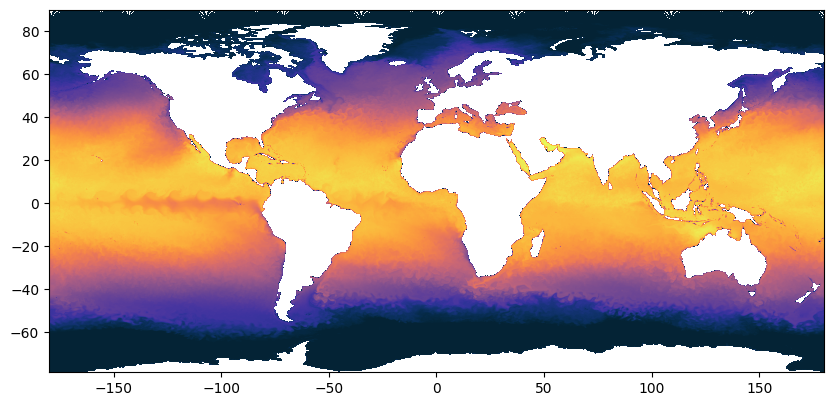

In [10]:
fig, ax = basic_dshader_plot(ds_sel, lon_range=[-180, 180], lat_range=[-90, 90], vminmax=[-2, 30], cmap=cmocean.cm.thermal)

### adapt ticks

In [11]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from   cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


In [12]:
def dshader_plot_map(var, lon_range, lat_range, vminmax=None, cmap='plasma'):
    projection = ccrs.PlateCarree()
    if lon_range is None:
        lon_range = [-180, 180]
    if lat_range is None:
        lat_range = [-90, 90]
        
    fig, ax = plt.subplots(figsize=(10,5), subplot_kw={'projection': projection})
    fig.canvas.draw_idle()  # necessary to make things work

    #-- transform radians to geodetic coordinates
    coords = projection.transform_points(
                            ccrs.Geodetic(),
                            np.rad2deg(var.clon.values),
                            np.rad2deg(var.clat.values))
    # Get the data in a dataframe to use dasher plot
    df = pd.DataFrame(data={
        "var": np.squeeze(var.values),
        "x": coords[:,0], 
        "y": coords[:,1],
    },)
    
    df = df[(df['x']>lon_range[0]) & (df['x']<lon_range[1]) & 
            (df['y']>lat_range[0]) & (df['y']<lat_range[1])]
    
    artist = dsshow(df, dshader.Point('x', 'y'), dshader.mean('var'), cmap=cmap, vmax=vminmax[1], vmin=vminmax[0], ax=ax)
    ax.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=5)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8, zorder=6)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, zorder=7)
    # add longitude and latitude labels
    ax.set_xticks(np.arange(lon_range[0], lon_range[1], 4), crs=projection)
    ax.set_yticks(np.arange(lat_range[0], lat_range[1], 4), crs=projection)
    ax.xaxis.set_major_locator(plt.MaxNLocator(5)) # type: ignore
    ax.yaxis.set_major_locator(plt.MaxNLocator(5)) # type: ignore

    # apply the default formatter to the ticks
    ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER)
    ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
    return fig, ax

/Users/mepke/miniconda3/envs/tapgfd/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/Users/mepke/miniconda3/envs/tapgfd/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


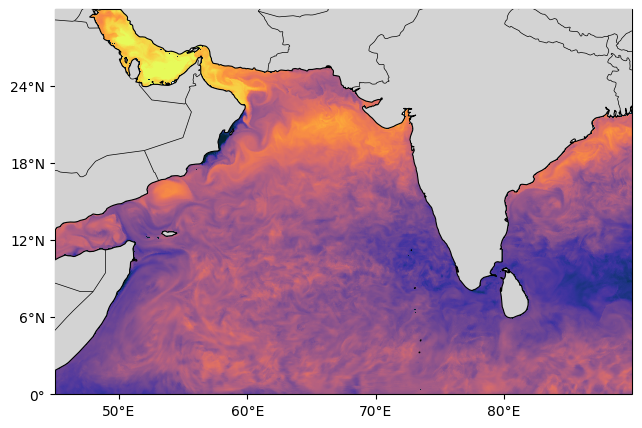

In [13]:
fig, ax = dshader_plot_map(ds_sel, lon_range=[45, 90], lat_range=[0, 30], vminmax=[24, 30], cmap=cmocean.cm.thermal)

## dshader and projections

In [14]:
def plot_dshader_proj(var, projection, extent, vmin, vmax, cmap, savefig, fig_path):
    #-- transform radians to geodetic coordinates
    coords = projection.transform_points(
                            ccrs.Geodetic(),
                            np.rad2deg(var.clon.values),
                            np.rad2deg(var.clat.values))

    #-- create data frame of the variable values and the geodetic coordinates.
    df = pd.DataFrame({'var': var.values, 'x': coords[:,0], 'y': coords[:,1]})
    fig, ax = plt.subplots(figsize=(10,5), subplot_kw={"projection": projection})
    fig.canvas.draw_idle()  # necessary to make things work


    artist = dsshow(df          = df,
                    glyph       = dshader.Point('x', 'y'),
                    aggregator  = dshader.mean('var'),
                    vmin        = vmin,
                    vmax        = vmax,
                    cmap        = cmap,
                    # plot_width  = 200,
                    # plot_height = 100,
                    ax          = ax)

    ax.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=10)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8, zorder=11)

    if extent is not None:
        ax.set_extent(extent)

    if savefig:
        plt.savefig(f'{fig_path}/test.png', dpi=250)
    return fig, ax


/Users/mepke/miniconda3/envs/tapgfd/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


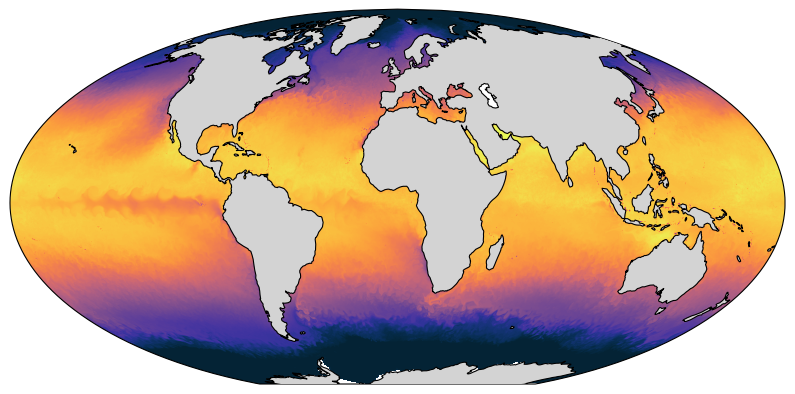

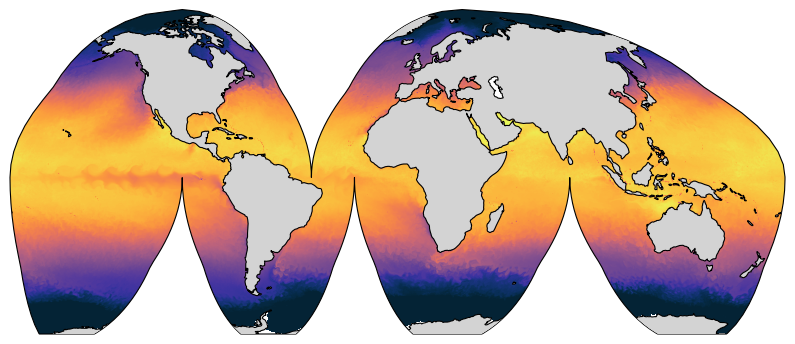

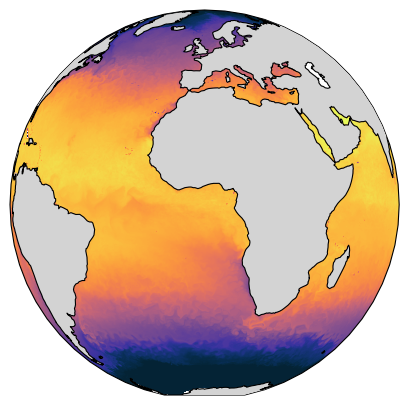

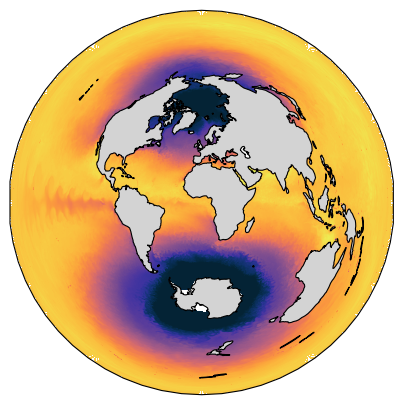

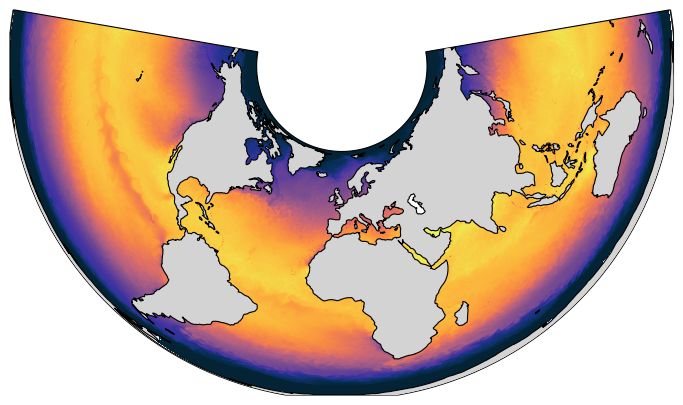

In [15]:
projections = [ccrs.Mollweide(), ccrs.InterruptedGoodeHomolosine(), ccrs.Orthographic(), ccrs.Sinusoidal(), ccrs.AzimuthalEquidistant(), ccrs.AlbersEqualArea()]
for i in range(len(projections)):
    fig, ax = plot_dshader_proj(ds_sel, projection = projections[i], extent=None, vmin=-2, vmax=30, cmap=cmocean.cm.thermal, savefig=False, fig_path=None)


## select number of pixel and save image

In [16]:
fig, ax = dshader_plot_map(ds_sel, lon_range=[70, 80], lat_range=[5, 10], vminmax=[24, 30], cmap=cmocean.cm.thermal)

/Users/mepke/miniconda3/envs/tapgfd/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


In [ ]:
def quick_plot(ax, data_array_var, projection, thrx=1, mp=5, **kwargs):
    fig.canvas.draw_idle() 
    cx, df_plot = get_data_frame_projection(projection, data_array_var)
    artist = dsshow(df_plot, ds.Point('lon', 'lat'), ds.mean('variable'), ax=ax,
                    shade_hook=lambda img: ds.transfer_functions.dynspread(img, threshold=thrx, max_px=mp, shape="square"),
                    **kwargs)
    return artist

In [17]:
from datashader import Canvas


In [18]:
def dshader_plot_mp(var, lon_range, lat_range, vminmax=None, cmap='plasma'):
    projection = ccrs.PlateCarree()
    if lon_range is None:
        lon_range = [-180, 180]
    if lat_range is None:
        lat_range = [-90, 90]
        
    fig, ax = plt.subplots(figsize=(10,5), subplot_kw={'projection': projection})
    fig.canvas.draw_idle()  # necessary to make things work
    # canvas = Canvas(plot_width=2000, plot_height=1000)


    #-- transform radians to geodetic coordinates
    coords = projection.transform_points(
                            ccrs.Geodetic(),
                            np.rad2deg(var.clon.values),
                            np.rad2deg(var.clat.values))
    # Get the data in a dataframe to use dasher plot
    df = pd.DataFrame(data={
        "var": np.squeeze(var.values),
        "x":   coords[:,0], 
        "y":   coords[:,1],
    },)
    
    df = df[(df['x']>lon_range[0]) & (df['x']<lon_range[1]) & 
            (df['y']>lat_range[0]) & (df['y']<lat_range[1])]
    
    # artist = dsshow(df, dshader.Point('x', 'y'), dshader.mean('var'), cmap=cmap, vmax=vminmax[1], vmin=vminmax[0], ax=ax)
    artist = dsshow(df          = df,
                    glyph       = dshader.Point('x', 'y'),
                    aggregator  = dshader.mean('var'),
                    vmin        = vminmax[0],
                    vmax        = vminmax[1],
                    cmap        = cmap,
                    aspect      = 'auto',
                    shade_hook  = lambda img: dshader.transfer_functions.dynspread(img, threshold=1, max_px=2, shape='square'),
                    # plot_width  = 200,
                    # plot_width  = 200,
                    # plot_height = 100,
                    ax          = ax)
    
    # extent = [lon_range[0], lon_range[1], lat_range[0], lat_range[1]]
    # ax.set_extent(extent)
    ax.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=5)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8, zorder=6)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, zorder=7)
    # add longitude and latitude labels
    ax.set_xticks(np.arange(lon_range[0], lon_range[1], 4), crs=projection)
    ax.set_yticks(np.arange(lat_range[0], lat_range[1], 4), crs=projection)
    ax.xaxis.set_major_locator(plt.MaxNLocator(5)) # type: ignore
    ax.yaxis.set_major_locator(plt.MaxNLocator(5)) # type: ignore

    # apply the default formatter to the ticks
    ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER)
    ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
    return fig, ax

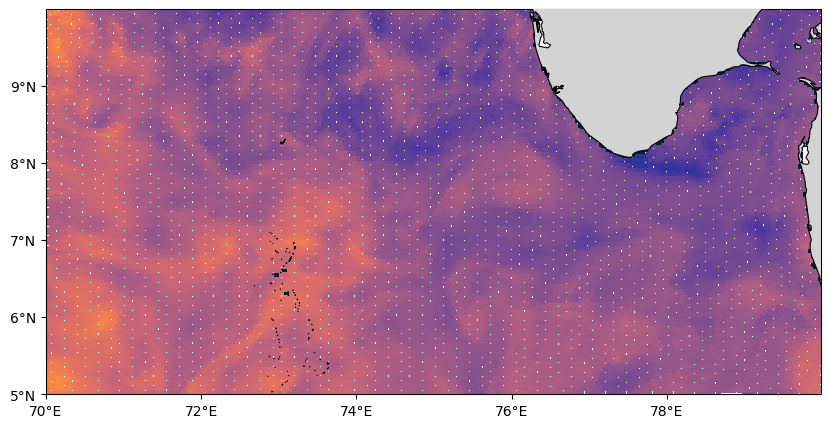

In [20]:
fig, ax = dshader_plot_mp(ds_sel, lon_range=[70, 80], lat_range=[5, 10], vminmax=[24, 28], cmap=cmocean.cm.thermal)